# Amazon Refine Food Review using knn by Simran Nagpurkar

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In [0]:
   #LOADING LIBRARIES

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import scipy as sp
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer                                  

# [1]. Reading Data

In [0]:
                    #LOADING OF DATA
    
conn=sqlite3.connect(r'C:\Users\SIMRAN\Desktop\database.sqlite')    
filtered_data = pd.read_sql_query("select * from reviews where score!=3",conn)

#print(filtered_data.head())---this command can be appply if we want to display the data

In [0]:
display=pd.read_sql_query(""" 
SELECT * 
FROM Reviews 
WHERE Score != 3  AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""",conn)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
def partition(x):
    if x < 3:
        return 0
    return 1
# here if a review score is greater than 3 then it will consider as a positive i.e 1 else negative(0)

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


The score column which has been in format(1,2,3,4,5) has been converted into binary i.e positive(1) and negative(0).
In our dataset it has total 525814 datapoints with 10 features.

# [2] Exploratory Data Analysis

# [2.1]Data Cleaning: Deduplication

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


In [0]:
# how much % of data is still left in dataset?
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [0]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## SELECTING 50K SAMPLE FROM DATASET

In [0]:
final = sorted_data[:50000]
print(final.shape)


(50000, 10)


In [0]:
final['Score'].value_counts()

1    42563
0     7437
Name: Score, dtype: int64

# [3] Preprocessing

# [3.1] Preprocessing Review Text


Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

ASTRONAUT ICE CREAM...WOW!  Who could not love this stuff...what a great stocking stuffer, basket filler, hostess gift selection (paired, perhaps, with a bottle of wine!)  Keep a few in your pocketbook for road trips (to be removed when the crankiness begins). An out of the norm, NOT run of the mill, DELIGHTFUL old time FAVORITE (plus, I love that it is not found on every supermarket shelf...keeps it all the more special!)


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:40<00:00, 1246.70it/s]


In [0]:
preprocessed_reviews[1500]

'astronaut ice cream wow could not love stuff great stocking stuffer basket filler hostess gift selection paired perhaps bottle wine keep pocketbook road trips removed crankiness begins norm not run mill delightful old time favorite plus love not found every supermarket shelf keeps special'

### Preprocessing for review summary

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# preprocessing for review summary!

preprocessed_sum = []

for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)

    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_sum.append(sentance.strip())

100%|██████████| 50000/50000 [00:25<00:00, 1929.56it/s]


# [4] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

## [4.1] Applying KNN brute force

### [4.1.1] Applying KNN brute force on BOW

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split
Y = final['Score']
X = preprocessed_reviews
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


#https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn


print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_cv), np.shape(y_cv))
print(np.shape(X_test), np.shape(y_test))

print("="*100)

#in scikit-learn documentation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)


(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)
After vectorizations
(22445, 29013) (22445,)
(11055, 29013) (11055,)
(16500, 29013) (16500,)


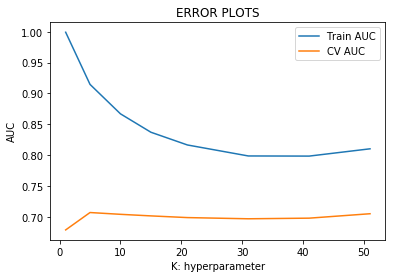

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix,  figsize = (5,3), class_names=[0,1],fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index= class_names, columns= class_names, )

    
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True,fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize= 16)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16 )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

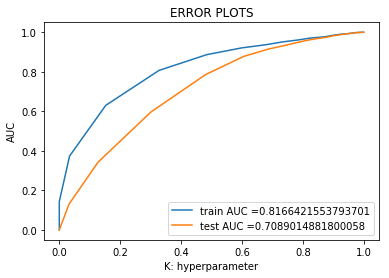

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

1. Train confusion matrix


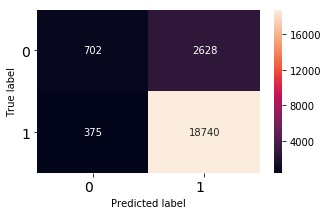

In [0]:
from sklearn.metrics import confusion_matrix
print("1. Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(X_train_bow)));

2. Test confusion matrix


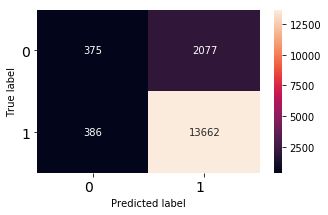

In [0]:
print("2. Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(X_test_bow)));

### [4.1.2] Applying KNN brute force on TFIDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)
print("="*100)


After vectorizations
(22445, 14610) (22445,)
(11055, 14610) (11055,)
(16500, 14610) (16500,)


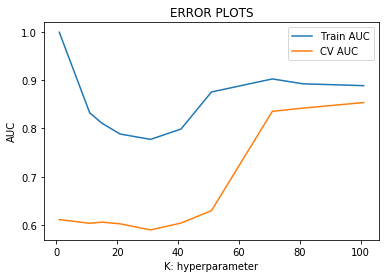

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1,11, 15, 21, 31, 41, 51 , 71,81,101]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tf_idf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tf_idf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

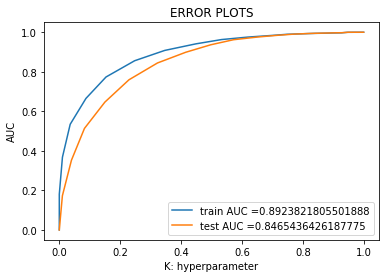

In [0]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=81)
neigh.fit(X_train_tf_idf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Train confusion matrix


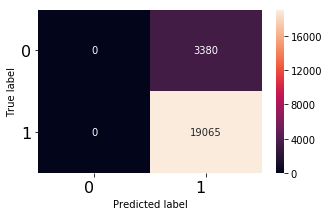

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(X_train_tf_idf)));


Test confusion matrix


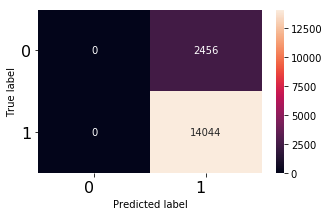

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(X_test_tf_idf))) ;

### [4.1.3] Applying KNN brute force on AVG W2V

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



i=0
Xtrain_review_words=[]
for sentance in X_train:
    Xtrain_review_words.append(sentance.split())
    
XCV_review_words=[]
for sentance in X_cv:
    XCV_review_words.append(sentance.split())
    
Xtest_review_words=[]
for sentance in X_test:
    Xtest_review_words.append(sentance.split())
    


w2v_model=Word2Vec(Xtrain_review_words,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
Xtrain_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(Xtrain_review_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xtrain_avg_w2v.append(sent_vec)
    

XCV_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(XCV_review_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    XCV_avg_w2v.append(sent_vec)
    

Xtest_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(Xtest_review_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xtest_avg_w2v.append(sent_vec)

number of words that occured minimum 5 times  9964
sample words  ['love', 'product', 'everything', 'hoped', 'would', 'arrived', 'quickly', 'great', 'condition', 'definitely', 'order', 'first', 'not', 'ball', 'holder', 'bother', 'really', 'everlasting', 'last', 'whole', 'lot', 'longer', 'dogs', 'inserted', 'many', 'licks', 'take', 'get', 'center', 'tootsie', 'roll', 'pop', 'world', 'may', 'never', 'know', 'chances', 'assorted', 'flavors', 'try', 'since', 'saw', 'mouth', 'unable', 'recall', 'ever', 'got', 'point', 'bit', 'suck']


100%|██████████| 16500/16500 [00:44<00:00, 373.95it/s]


In [0]:
print("After vectorizations")
print(np.shape(Xtrain_avg_w2v), np.shape(y_train))
print(np.shape(XCV_avg_w2v), np.shape(y_cv))
print(np.shape(Xtest_avg_w2v), np.shape(y_test))
print("="*100)

After vectorizations
(22445, 50) (22445,)
(11055, 50) (11055,)
(16500, 50) (16500,)


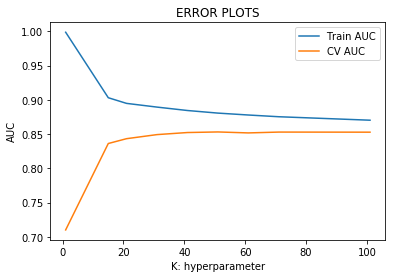

In [0]:
train_auc = []
cv_auc = []
K = [1, 15, 21, 31, 41, 51, 61, 71,101]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(Xtrain_avg_w2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(Xtrain_avg_w2v)[:,1]
    y_cv_pred =  neigh.predict_proba(XCV_avg_w2v)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

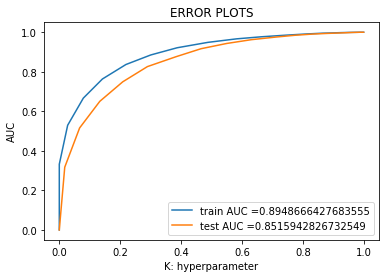

In [0]:
neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(Xtrain_avg_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(Xtrain_avg_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(Xtest_avg_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train confusion matrix


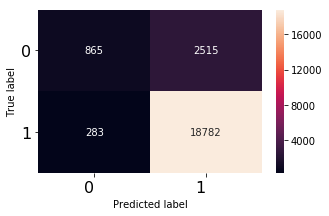

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(Xtrain_avg_w2v))) ;


Test confusion matrix


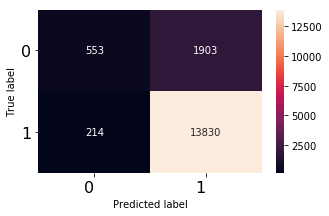

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(Xtest_avg_w2v))) ;

### [4.1.4] Applying KNN brute force on TFIDF W2V

In [0]:
i=0
Xtrain_review_words=[]
for sentance in X_train:
    Xtrain_review_words.append(sentance.split())
    
XCV_review_words=[]
for sentance in X_cv:
    XCV_review_words.append(sentance.split())
    
Xtest_review_words=[]
for sentance in X_test:
    Xtest_review_words.append(sentance.split())
      
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()


w2v_model=Word2Vec(Xtrain_review_words,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)



tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(Xtrain_review_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
           # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1
    
    
tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(Xtest_review_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1
    
    
tfidf_w2v_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(XCV_review_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_cv.append(sent_vec)
    row += 1










100%|██████████| 1769/1769 [00:16<00:00, 105.06it/s]


In [0]:
print("After vectorizations")
print(np.shape(tfidf_w2v_train), np.shape(y_train))
print(np.shape(tfidf_w2v_cv), np.shape(y_cv))
print(np.shape(tfidf_w2v_test), np.shape(y_test))
print("="*100)

After vectorizations
(22445, 50) (22445,)
(11055, 50) (11055,)
(16500, 50) (16500,)


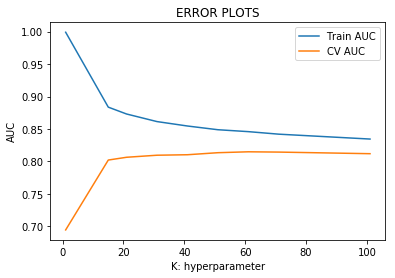

In [0]:
train_auc = []
cv_auc = []
K = [1, 15, 21, 31, 41, 51, 61, 71,101]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(tfidf_w2v_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_w2v_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_w2v_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

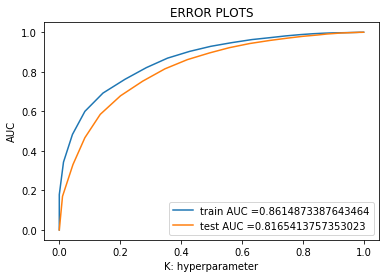

In [0]:
neigh = KNeighborsClassifier(n_neighbors=31)
neigh.fit(tfidf_w2v_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_w2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_w2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.ylabel("AUC")
plt.xlabel("K: hyperparameter")
plt.legend()
plt.title("ERROR PLOTS")
plt.show()


Train confusion matrix


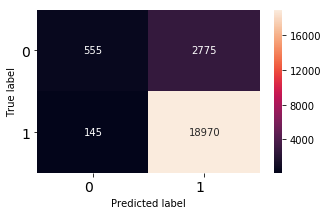

In [0]:
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(tfidf_w2v_train)));


Test confusion matrix


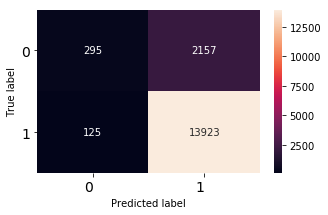

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(tfidf_w2v_test)));

# [4.2] Applying KNN kd-tree

### SPLITTING INTO 20K DATA SAMPLE

In [0]:
final = sorted_data[:20000]
print(final.shape)


(20000, 10)


In [0]:
final['Score'].value_counts()

1    17081
0     2919
Name: Score, dtype: int64

### [4.2.1] Applying KNN kd-tree on BOW, SET 5

In [0]:
X, X_test, Y, y_test = train_test_split(X, Y, test_size=0.6) # this is random splitting

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train).toarray()
X_cv_bow = vectorizer.transform(X_cv).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()


print("After vectorizations")
print("Type of Xtrain-",type(X_train_bow))
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)



After vectorizations
Type of Xtrain- <class 'numpy.ndarray'>
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


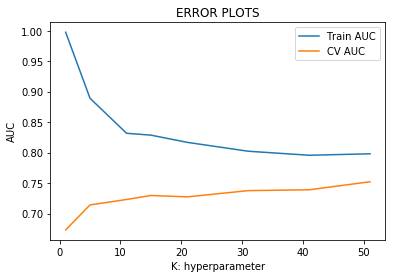

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
K = [1, 5, 11, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


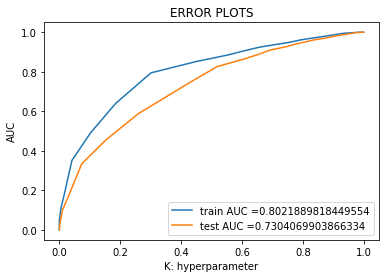

In [0]:

neigh = KNeighborsClassifier(n_neighbors=31,algorithm='kd_tree',n_jobs=-1)
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train confusion matrix


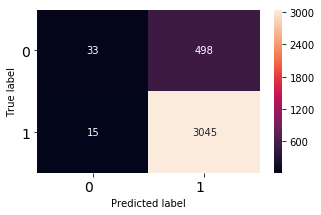

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(X_train_bow)));

Test confusion matrix


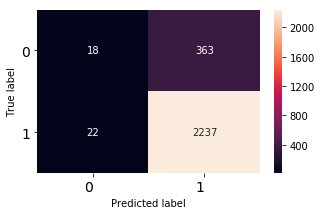

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(X_test_bow)));

### [4.2.2] Applying KNN kd-tree on TFIDF, SET 6



In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)


X_train_tf_idf = tf_idf_vect.transform(X_train).toarray()
X_cv_tf_idf = tf_idf_vect.transform(X_cv).toarray()
X_test_tf_idf = tf_idf_vect.transform(X_test).toarray()

print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)
print("="*100)



After vectorizations
(8978, 5807) (8978,)
(4422, 5807) (4422,)
(6600, 5807) (6600,)


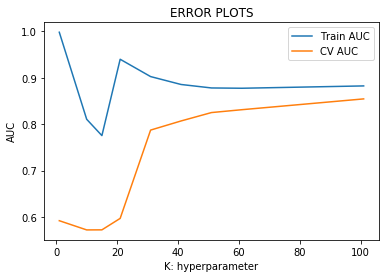

In [0]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
K = [1,10, 15, 21, 31, 41, 51, 61, 101]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(X_train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tf_idf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tf_idf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

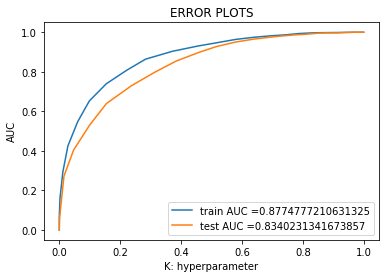

In [0]:
neigh = KNeighborsClassifier(n_neighbors=61,algorithm='kd_tree',n_jobs=-1)
neigh.fit(X_train_tf_idf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train confusion matrix


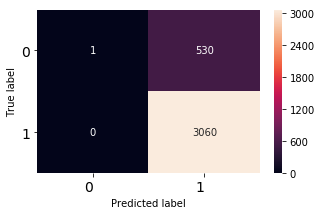

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(X_train_tf_idf)));


Test confusion matrix


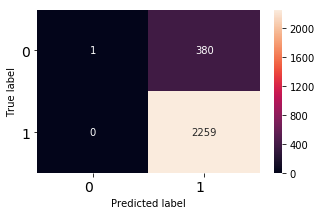

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(X_test_tf_idf)));

### [4.2.3] Applying KNN kd-tree on AVG W2V, SET 3

In [0]:
i=0
Xtrain_review_words=[]
for sentance in X_train:
    Xtrain_review_words.append(sentance.split())
    
XCV_review_words=[]
for sentance in X_cv:
    XCV_review_words.append(sentance.split())
    
Xtest_review_words=[]
for sentance in X_test:
    Xtest_review_words.append(sentance.split())
    


w2v_model=Word2Vec(Xtrain_review_words,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
Xtrain_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(Xtrain_review_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xtrain_avg_w2v.append(sent_vec)
    
XCV_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(XCV_review_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    XCV_avg_w2v.append(sent_vec)

Xtest_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(Xtest_review_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xtest_avg_w2v.append(sent_vec)

number of words that occured minimum 5 times  6023
sample words  ['first', 'tried', 'yamamotoyama', 'green', 'tea', 'japanese', 'restaurant', 'enjoying', 'much', 'asked', 'would', 'tell', 'brand', 'brought', 'box', 'told', 'use', 'usually', 'make', 'cups', 'teabag', 'since', 'like', 'mine', 'mild', 'flavor', 'wonderful', 'price', 'good', 'actually', 'quality', 'highly', 'recommend', 'product', 'anyone', 'enjoys', 'great', 'cup', 'not', 'realize', 'bought', 'going', 'small', 'treat', 'anything', 'larger', 'yorkie', 'might', 'handful', 'dog']


100%|██████████| 6600/6600 [00:06<00:00, 1050.99it/s]


In [0]:
print("After vectorizations")
print(np.shape(Xtrain_avg_w2v), np.shape(y_train))
print(np.shape(XCV_avg_w2v), np.shape(y_cv))
print(np.shape(Xtest_avg_w2v), np.shape(y_test))
print("="*100)

After vectorizations
(8978, 50) (8978,)
(4422, 50) (4422,)
(6600, 50) (6600,)


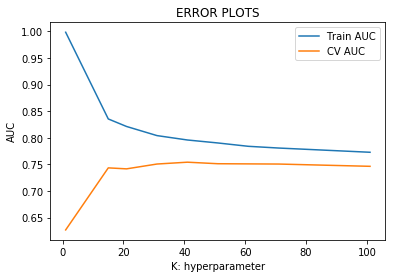

In [0]:
train_auc = []
cv_auc = []
K = [1, 15, 21, 31, 41, 51, 61, 71,101]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(Xtrain_avg_w2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(Xtrain_avg_w2v)[:,1]
    y_cv_pred =  neigh.predict_proba(XCV_avg_w2v)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


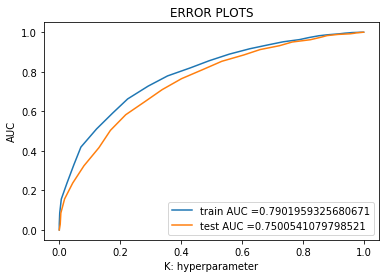

In [0]:
neigh = KNeighborsClassifier(n_neighbors=51,algorithm='kd_tree',n_jobs=-1)
neigh.fit(Xtrain_avg_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(Xtrain_avg_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(Xtest_avg_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train confusion matrix


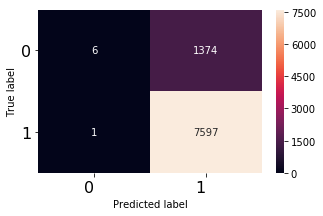

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(Xtrain_avg_w2v)));

Test confusion matrix


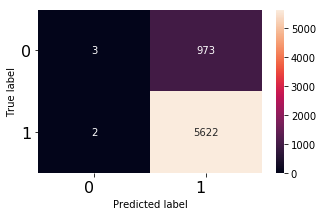

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(Xtest_avg_w2v))) ;

### [4.2.4] Applying KNN kd-tree on TFIDF W2V, SET 4

In [0]:
i=0
Xtrain_review_words=[]
for sentance in X_train:
    Xtrain_review_words.append(sentance.split())
    
XCV_review_words=[]
for sentance in X_cv:
    XCV_review_words.append(sentance.split())
    
Xtest_review_words=[]
for sentance in X_test:
    Xtest_review_words.append(sentance.split())
    

    
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()


w2v_model=Word2Vec(Xtrain_review_words,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)



tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(Xtrain_review_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1
    
    
tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(Xtest_review_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1
    
    
tfidf_w2v_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(XCV_review_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_cv.append(sent_vec)
    row += 1

100%|██████████| 4422/4422 [00:25<00:00, 174.01it/s]


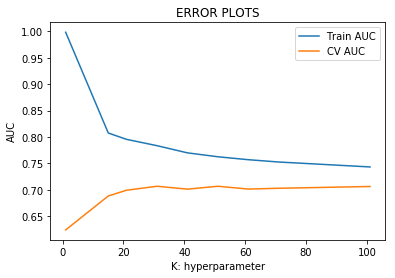

In [0]:
train_auc = []
cv_auc = []
K = [1, 15, 21, 31, 41, 51, 61, 71,101]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(tfidf_w2v_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_w2v_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_w2v_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.ylabel("AUC")
plt.xlabel("K: hyperparameter")
plt.legend()
plt.title("ERROR PLOTS")
plt.show()
    


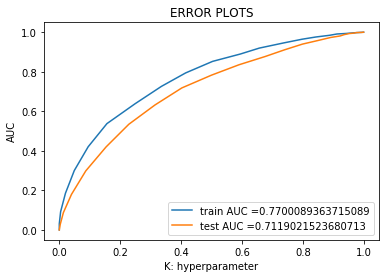

In [0]:

neigh = KNeighborsClassifier(n_neighbors=41)
neigh.fit(tfidf_w2v_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_w2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_w2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.ylabel("AUC")
plt.xlabel("K: hyperparameter")
plt.legend()
plt.title("ERROR PLOTS")
plt.show()
    



Train confusion matrix


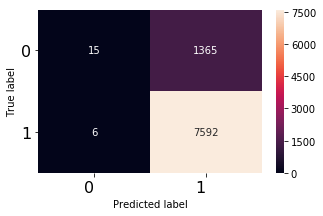

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print_confusion_matrix(confusion_matrix(y_train, neigh.predict(tfidf_w2v_train)),class_names=[0,1],figsize=(5,3));


Test confusion matrix


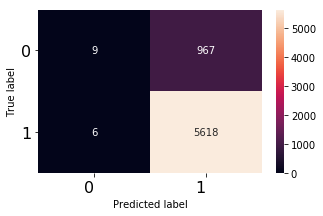

In [0]:
print("Test confusion matrix")
print_confusion_matrix(confusion_matrix(y_test, neigh.predict(tfidf_w2v_test)),class_names=[0,1],figsize=(5,3));



# [5] Conclusions

In [0]:
#http://zetcode.com/python/prettytable/


from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "ALGO", "Hyperparameter", "AUC Value"]
x.add_row(["BOW","BRUTE-FORCE",21 , 0.70])
x.add_row(["TFIDF","BRUTE-FORCE", 81 , 0.84])
x.add_row(["AVG W2V","BRUTE-FORCE", 21, 0.85])
x.add_row(["TFIDF W2V", "BRUTE-FORCE",31, 0.81])


x.add_row(["BOW","KD_TREE", 31, 0.73])
x.add_row(["TFIDF", "KD_TREE", 61, 0.83])
x.add_row(["AVG W2V","KD_TREE", 41, 0.75])
x.add_row(["TFIDF W2V","KD_TREE", 41, 0.71])

print(x)

+------------+-------------+----------------+-----------+
| Vectorizer |     ALGO    | Hyperparameter | AUC Value |
+------------+-------------+----------------+-----------+
|    BOW     | BRUTE-FORCE |       21       |    0.7    |
|   TFIDF    | BRUTE-FORCE |       81       |    0.84   |
|  AVG W2V   | BRUTE-FORCE |       21       |    0.85   |
| TFIDF W2V  | BRUTE-FORCE |       31       |    0.81   |
|    BOW     |   KD_TREE   |       31       |    0.73   |
|   TFIDF    |   KD_TREE   |       61       |    0.83   |
|  AVG W2V   |   KD_TREE   |       41       |    0.75   |
| TFIDF W2V  |   KD_TREE   |       51       |    0.72   |
+------------+-------------+----------------+-----------+
